In [441]:
col = ['Player',
 'Team',
 'Season',
 'Season Type',
 'Games',
 'Above the Break 3-Usage',
 'Mid-Range-Usage',
 'In The Paint (Non-RA)-Usage',
 'Restricted Area-Usage',
 'Right Corner 3-Usage',
 'Left Corner 3-Usage',

 'Above the Break 3 %',
 'Mid-Range %',
 'In The Paint (Non-RA) %',
 'Restricted Area %',
 'Right Corner 3 %',
 'Left Corner 3 %',

 'Personal Fouls PG',
 'Charges Drawn',
 'Off. Fouls Drawn',
 'Off. Fouls',

 'Defensive 3 Seconds',
 'Shooting Fouls Committed',
 'Lost Ball Fouls',



 'Defensive Goaltendings',


 'Blocks Against',

 'Total Points',
 'FGM_x',
 'FGA_x',
 'FG%_x',

 '3FGM',
 '3FGA',
 '3FG%',

 'FTM_x',
 'FTA_x',
 'FT%_x',


 'Assisted FG Pct.',
 'Blocked FG Pct.',
 'Last Min. FGM',
 'Last Min. FGA',
 'Last Min. FG%',
 'Avg. Shot Dist.',
 'Avg. Made Shot Dist.',
       
       
 'FT Rate',
 'Triple Doubles',
 'Double Doubles',
 '25+ Pts Games',
 '10+ Reb Games',
 '10+ Ast Games',
 '3+ Blk Games',
 '3+ Stl Games',
 '3+ 3PTM Games',
       

 'Bad Pass TO PG',
 'Lost Ball TO PG',
 'Traveling PG',
 'Out of Bounds TO PG',
       

 'Jump Shots',
 'Layups',
 'Dunks',
 'Tip-ins',

       
 'Min',
 'Pts',
 'OReb',
 'Dreb',
 'Ast',
 'Stl',
 'Blk',
 'FGM_y',
 'FGA_y',
 '3PTM',
 '3PTA',
 'FTM_y',
 'FTA_y',

 'Four Point Plays',
 'Completed Four Point Plays',
 'And One',
 'Completed Three Point Plays',
 'Extra Free Throw Percentage',
 'Free Throw Rate Difference',
       

 'Assisted FG %',
 'Assisted 2Pts %',
 'Assisted 3Pts %',
 'Assisted Dunk %',
 'Assisted Layup %',
 'Assisted Jump Shot %',
 'Assists to Dunks PG',
 'Assists to Layups PG',
 'Assists to Jump Shots PG',
 'Assists to 3 Pointers PG',
 'Avg. Assisted Shot Distance',
 'Avg. Assisted Jump Shot Distance',
       
 'Pos']

In [438]:
len(col)

92

In [442]:
pd.options.display.max_columns = 160
pd.options.display.max_rows = 350
%matplotlib inline


import sys
sys.path.append('/Users/sinsanghun/anaconda/lib/python2.7/site-packages')

In [568]:
data = pd.read_csv("player.csv")
data = data.iloc[:,1:]

data = data[data["Games"]>=40]
data.shape

(5970, 152)

In [569]:
data = data[col]

In [570]:
train = data[data["Season"]!="2016-2017"]
dfy = train[["Pos"]]
dfX = train.iloc[:, 4:91]

In [571]:
test = data[data["Season"]=="2016-2017"]
test_y = test[["Pos"]]
test_X = test.iloc[:, 4:91]

# LDA

In [572]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True).fit(dfX, dfy)

In [573]:
from sklearn.metrics import confusion_matrix

y_true = test_y
y_pred = lda.predict(test_X)
confusion_matrix(y_true, y_pred)

array([[22, 23,  0,  2,  0],
       [ 8, 37,  0, 17,  2],
       [ 0,  0, 41,  0, 14],
       [ 0,  6,  0, 25, 20],
       [ 0,  1,  5, 13, 86]])

In [574]:
from sklearn.metrics import *

target_names = ["C", "PF", "PG", "SF", "sG"]
print(classification_report(y_true, y_pred, target_names=target_names))
print(accuracy_score(y_true, y_pred))

             precision    recall  f1-score   support

          C       0.73      0.47      0.57        47
         PF       0.55      0.58      0.56        64
         PG       0.89      0.75      0.81        55
         SF       0.44      0.49      0.46        51
         sG       0.70      0.82      0.76       105

avg / total       0.67      0.66      0.65       322

0.655279503106


# Xgboost

In [557]:
import xgboost
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=5, gamma=0.1).fit(dfX, dfy)

In [558]:
from sklearn.metrics import confusion_matrix
y_true = test_y
y_pred = model_xgb.predict(test_X)
confusion_matrix(y_true, y_pred)

array([[ 19,  28,   0,   8,   0],
       [  6,  44,   0,  25,   4],
       [  0,   0,  47,   0,  17],
       [  0,   5,   0,  27,  28],
       [  0,   1,  11,   8, 105]])

In [559]:
from sklearn.metrics import *

target_names = ["C", "PF", "PG", "SF", "SG"]
print(classification_report(y_true, y_pred, target_names=target_names))
print(accuracy_score(y_true, y_pred))

             precision    recall  f1-score   support

          C       0.76      0.35      0.47        55
         PF       0.56      0.56      0.56        79
         PG       0.81      0.73      0.77        64
         SF       0.40      0.45      0.42        60
         SG       0.68      0.84      0.75       125

avg / total       0.65      0.63      0.62       383

0.631853785901


# 모형 최적화

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe_svc = Pipeline([('clf', xgboost.XGBClassifier(n_estimators=100))])

param_range = [0.001, 0.02, 0.04, 0.07]
param_depth = [5]
param_grid = [
    {'clf__gamma' : param_range, 'clf__max_depth' : param_depth }]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=4)

gs.fit(np.array(dfX), np.array(dfy).flatten())

print(gs.cv_results_["mean_test_score"])
print(gs.best_score_)
print(gs.best_params_)

[ 0.65081043  0.65398168  0.6564482   0.65891473]
0.658914728682
{'clf__gamma': 0.07, 'clf__max_depth': 5}


# PCA 

In [575]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

# 데이터를 넣고 n에는 몇 개의 주성분으로 만들 것인지에 대한 정수
# 표준화 + PCA 다 해주는 함수 
def pca(data, n):
    data = StandardScaler().fit_transform(data)
    data = pd.DataFrame(data)
    col = [ "PC" + str(x+1) for x in range(n)]
    tempPCA = sklearnPCA(n_components=n)
    newIndex = tempPCA.fit_transform(data)
    newData = pd.DataFrame(newIndex)
    newData.columns = col
    return newData, tempPCA

In [576]:
pcaX, PCA = pca(dfX, 2)

In [577]:
PCA.explained_variance_ratio_

array([ 0.27402842,  0.17338965])

In [578]:
pcaX["pos"] = dfy

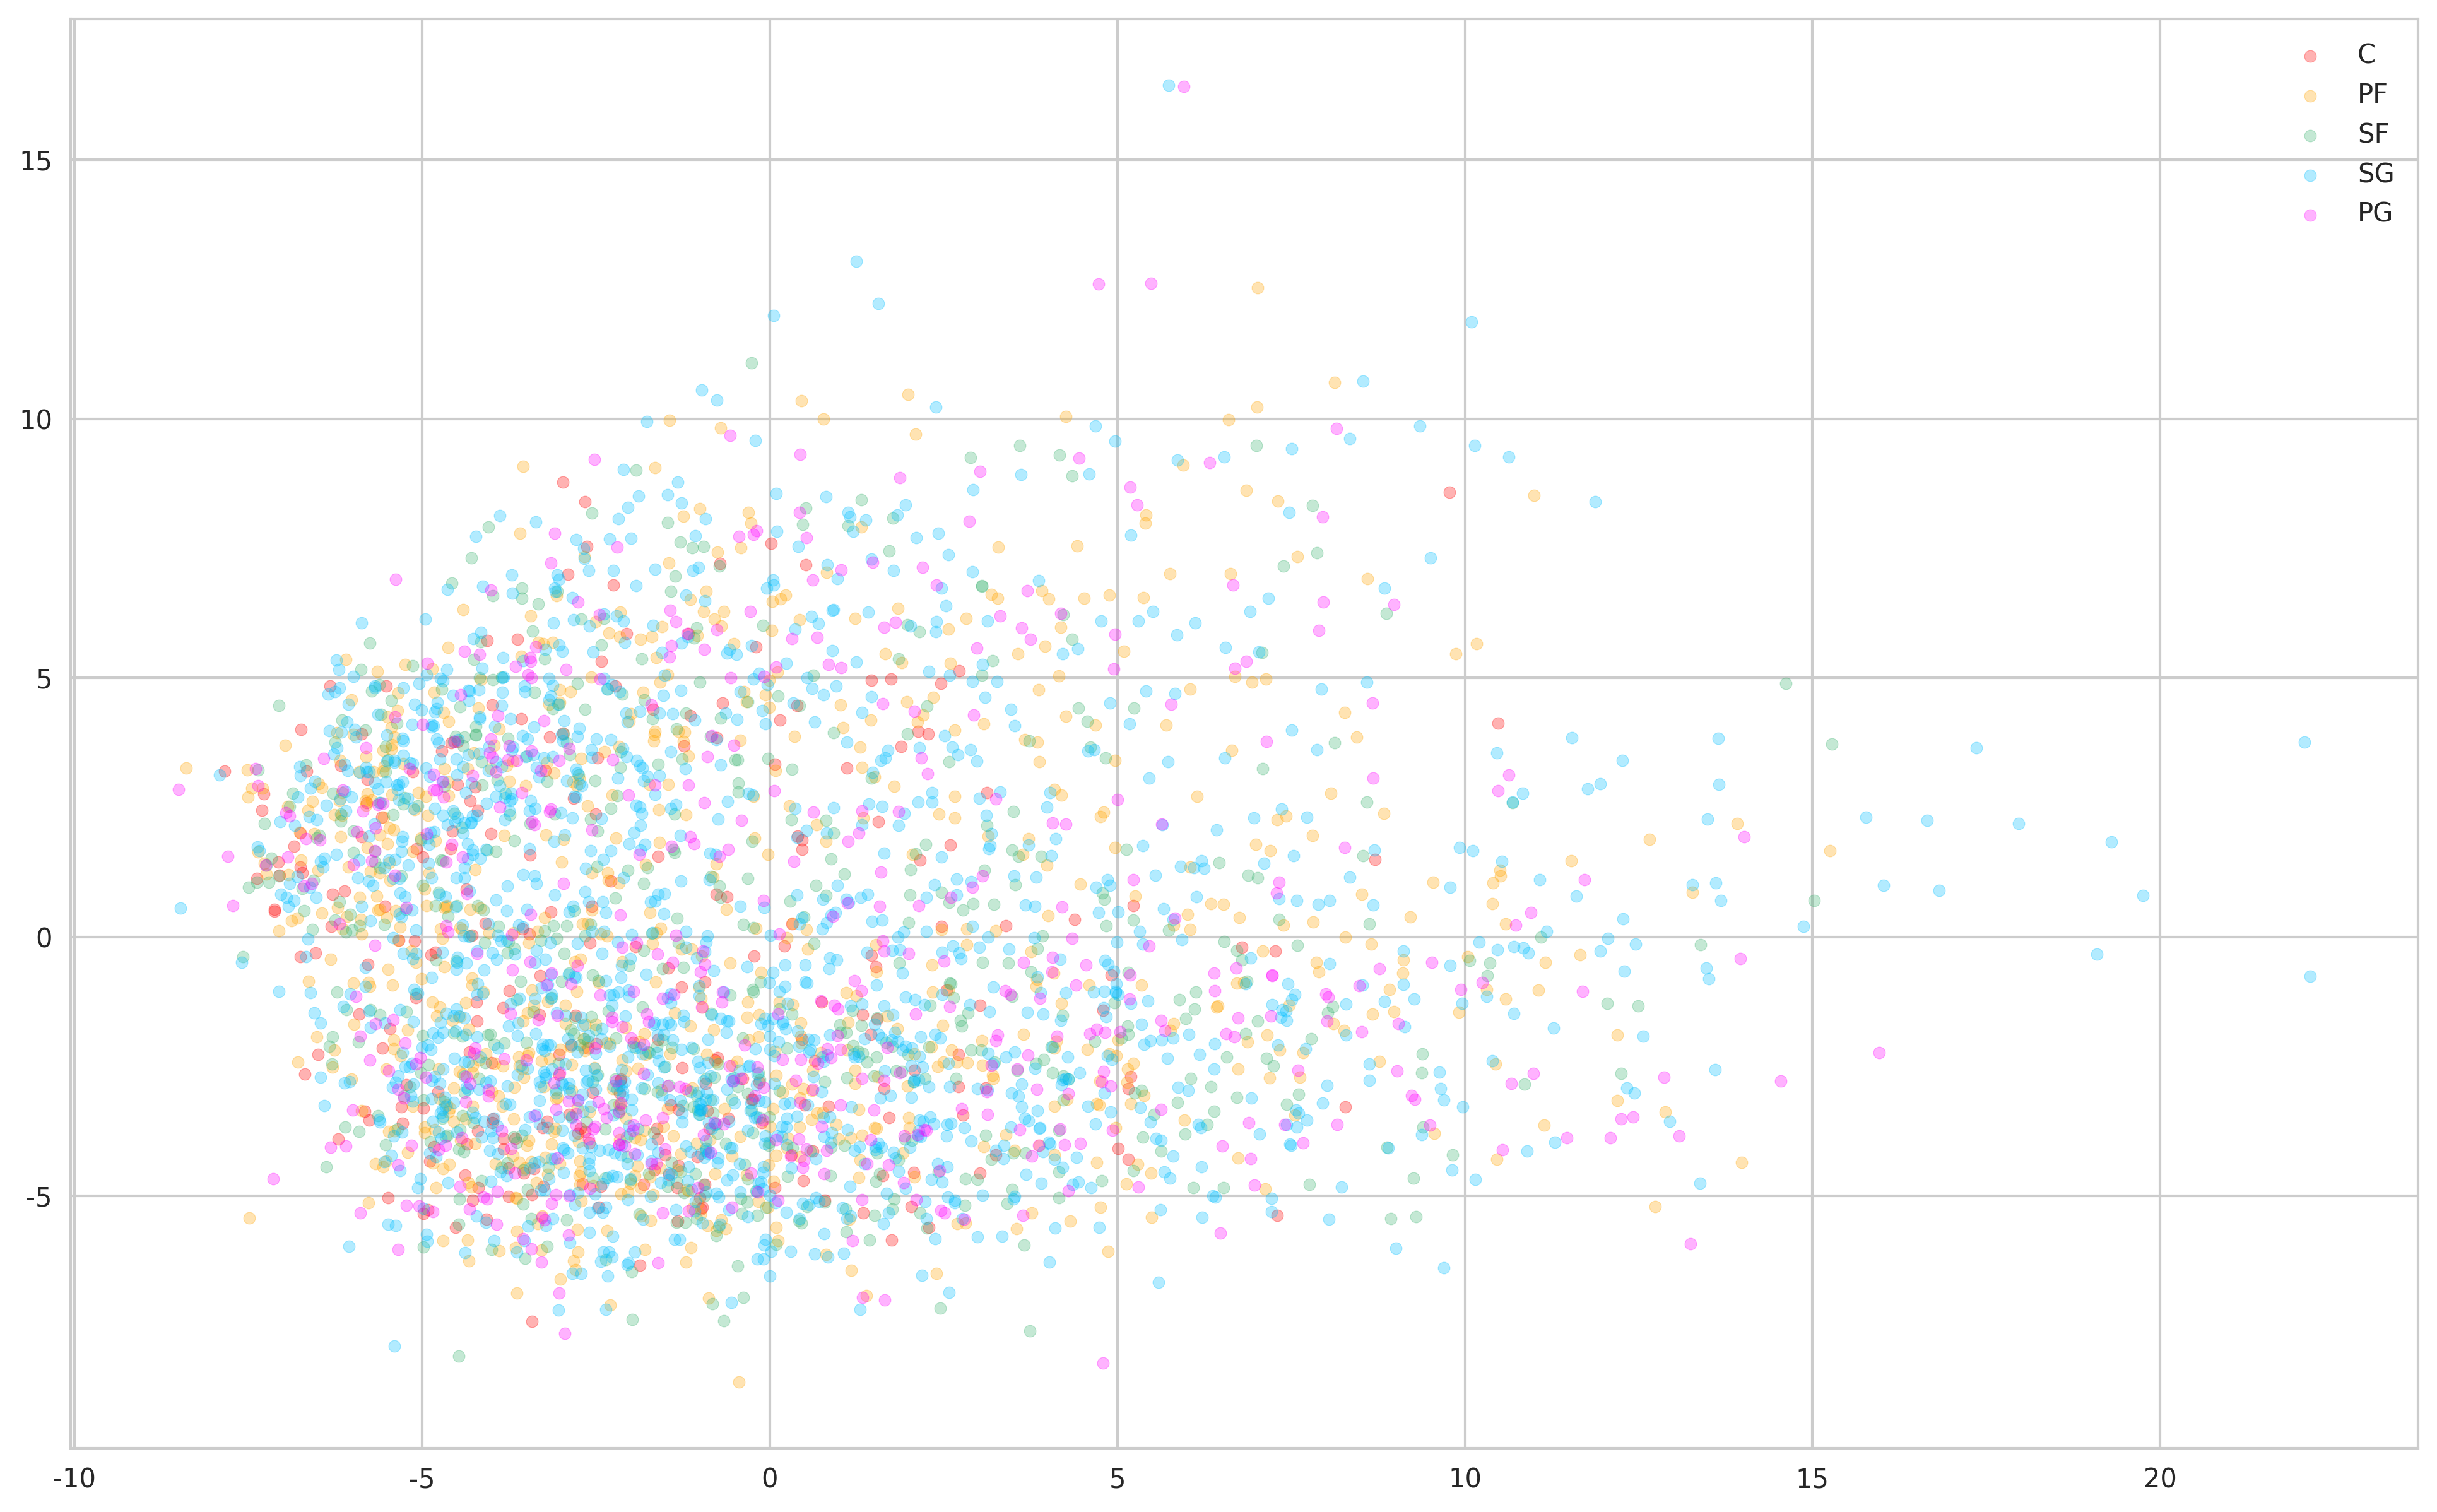

In [579]:
plt.figure(figsize=(16,10),dpi=300)
plt.scatter(pcaX[pcaX["pos"]=="C"].iloc[:,0], pcaX[pcaX["pos"]=="C"].iloc[:,1], color="red", marker="o", s=20, alpha=0.3, label="C")
plt.scatter(pcaX[pcaX["pos"]=="PF"].iloc[:,0], pcaX[pcaX["pos"]=="PF"].iloc[:,1], color="orange", marker="o", s=20, alpha=0.3, label="PF")
plt.scatter(pcaX[pcaX["pos"]=="SF"].iloc[:,0], pcaX[pcaX["pos"]=="SF"].iloc[:,1], color="mediumseagreen", marker="o", s=20, alpha=0.3, label="SF")
plt.scatter(pcaX[pcaX["pos"]=="SG"].iloc[:,0], pcaX[pcaX["pos"]=="SG"].iloc[:,1], color="deepskyblue", marker="o", s=20, alpha=0.3, label="SG")
plt.scatter(pcaX[pcaX["pos"]=="PG"].iloc[:,0], pcaX[pcaX["pos"]=="PG"].iloc[:,1], color="magenta", marker="o", s=20, alpha=0.3, label="PG")
plt.legend()
plt.show()

In [278]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init="k-means++").fit(pcaX)
model = model.predict(pcaX)

In [279]:
pcaX["cluster"] = model

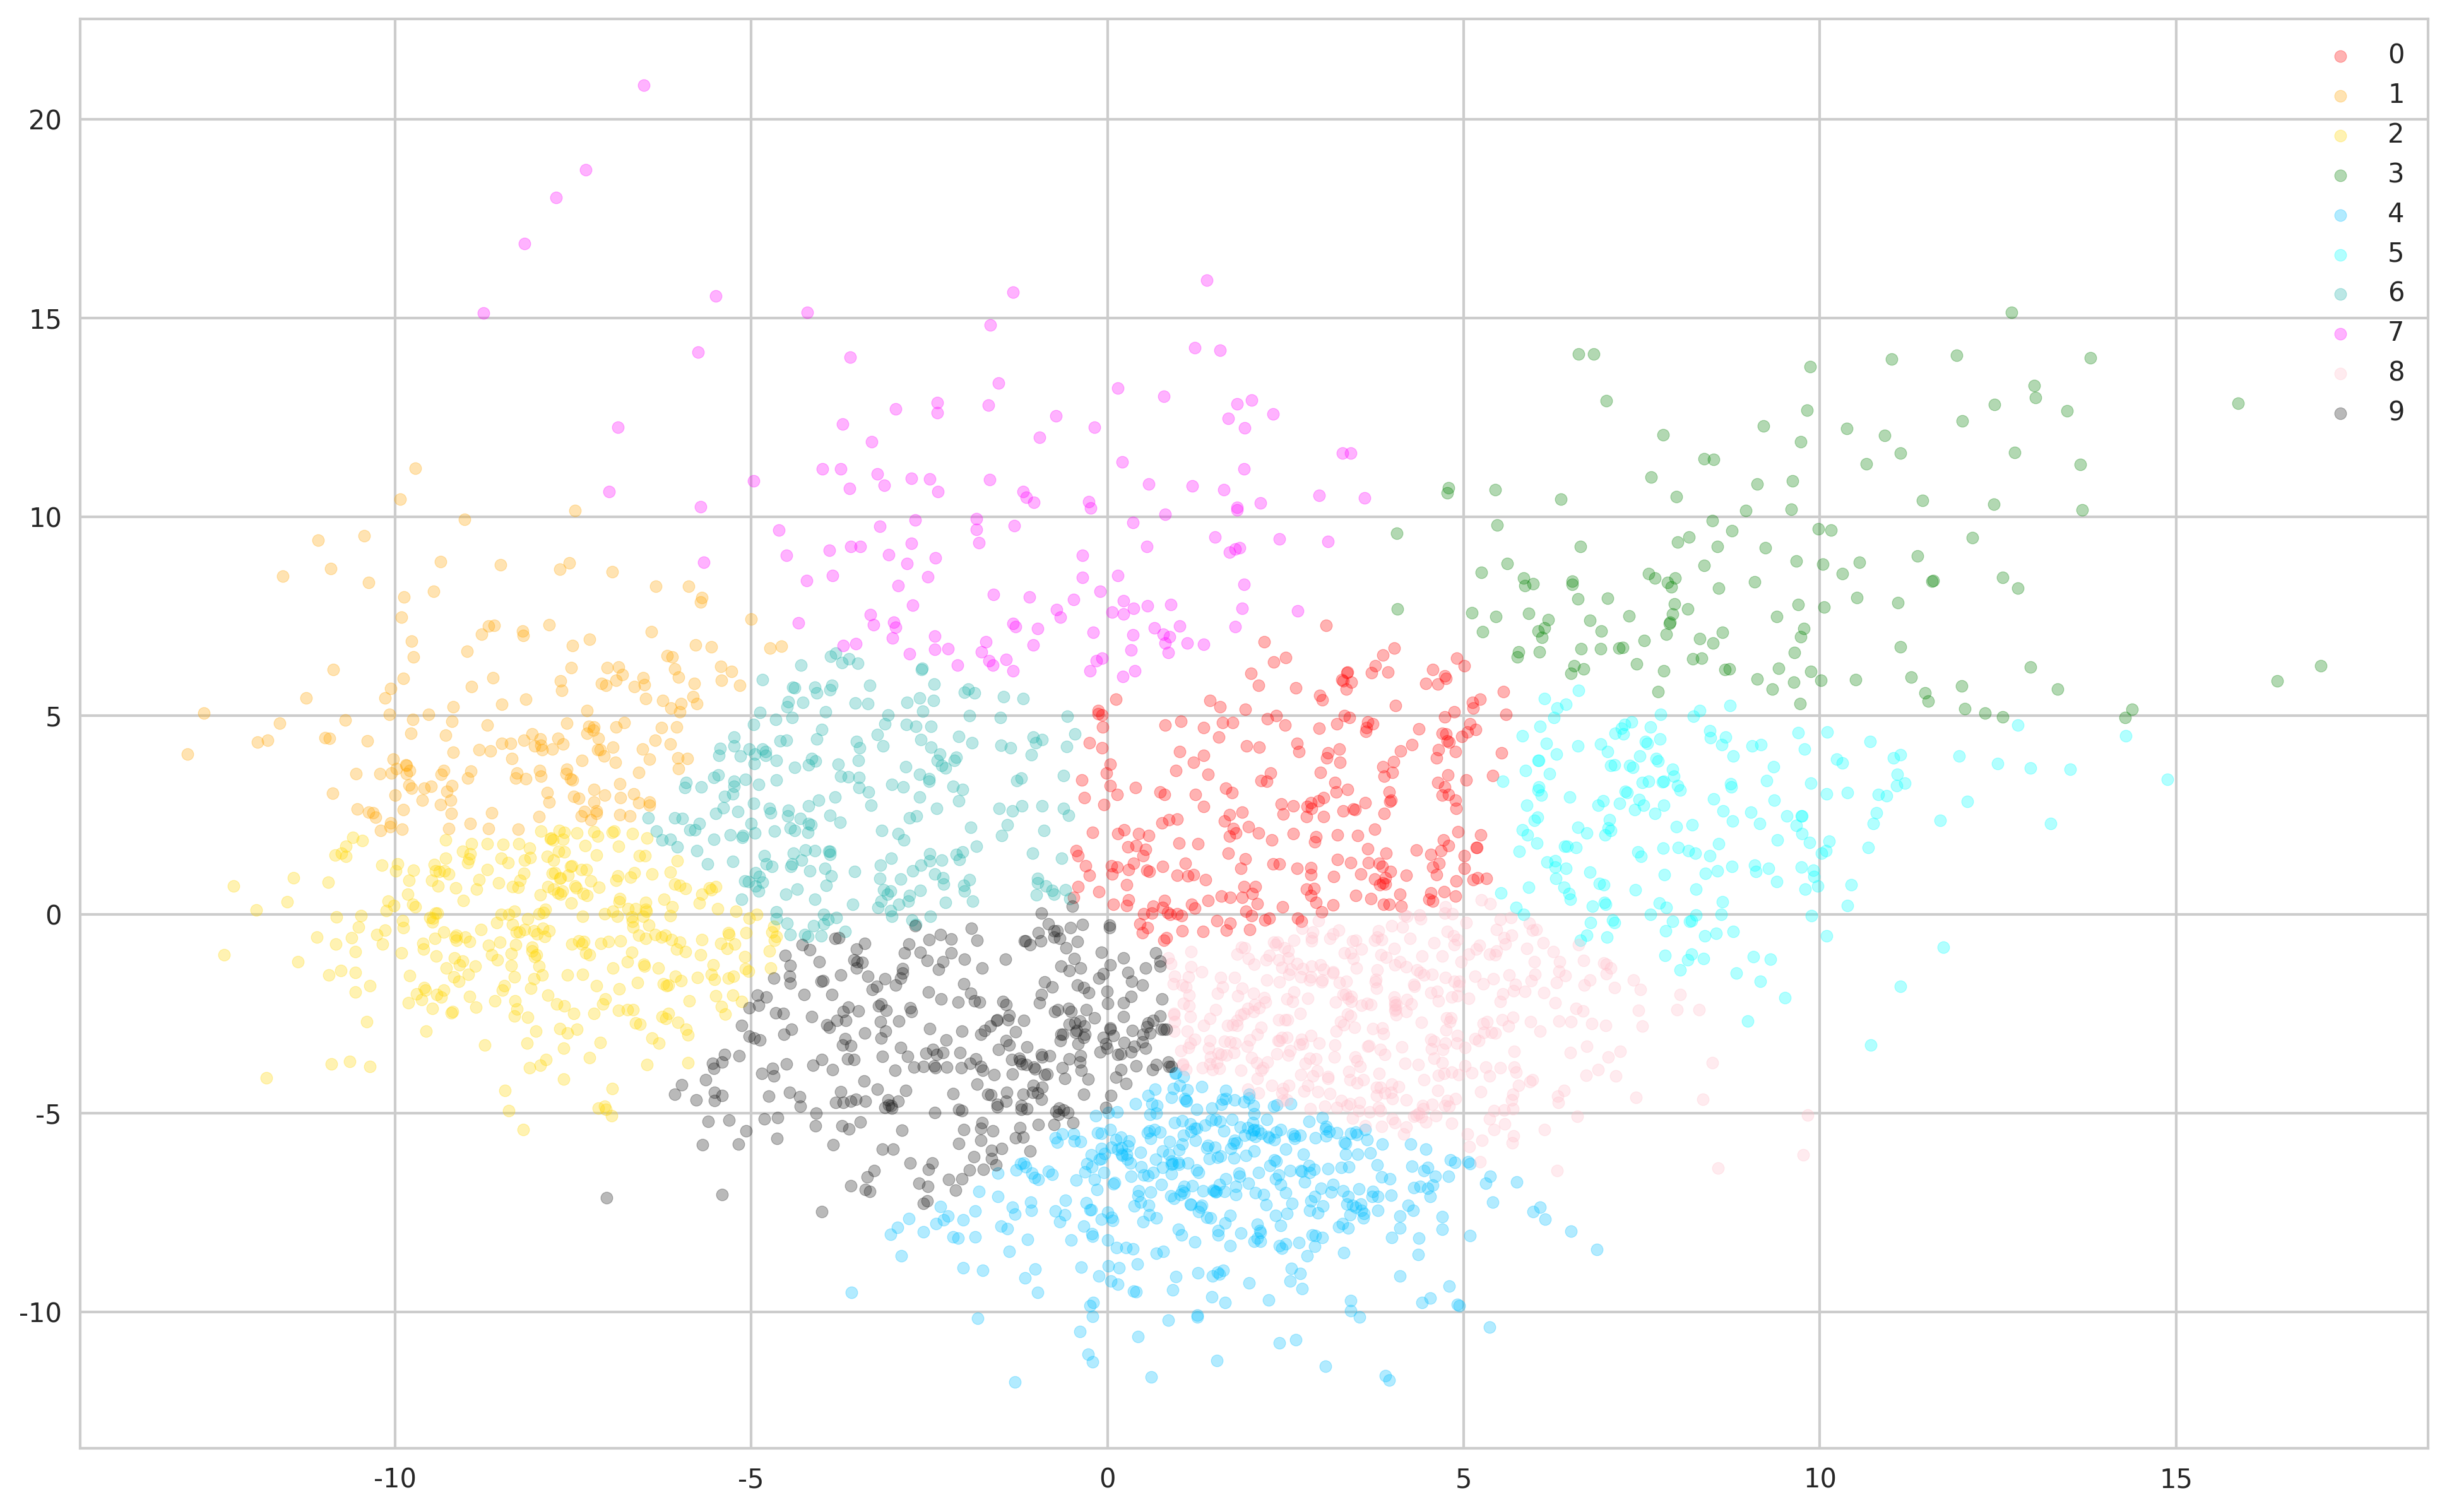

In [280]:
plt.figure(figsize=(16,10),dpi=300)
plt.scatter(pcaX[pcaX["cluster"]==0].iloc[:,0], pcaX[pcaX["cluster"]==0].iloc[:,1], color="red", marker="o", s=20, alpha=0.3, label="0")
plt.scatter(pcaX[pcaX["cluster"]==1].iloc[:,0], pcaX[pcaX["cluster"]==1].iloc[:,1], color="orange", marker="o", s=20, alpha=0.3, label="1")
plt.scatter(pcaX[pcaX["cluster"]==2].iloc[:,0], pcaX[pcaX["cluster"]==2].iloc[:,1], color="gold", marker="o", s=20, alpha=0.3, label="2")
plt.scatter(pcaX[pcaX["cluster"]==3].iloc[:,0], pcaX[pcaX["cluster"]==3].iloc[:,1], color="green", marker="o",s=20, alpha=0.3, label="3")
plt.scatter(pcaX[pcaX["cluster"]==4].iloc[:,0], pcaX[pcaX["cluster"]==4].iloc[:,1], color="deepskyblue", marker="o", s=20, alpha=0.3, label="4")
plt.scatter(pcaX[pcaX["cluster"]==5].iloc[:,0], pcaX[pcaX["cluster"]==5].iloc[:,1], color="cyan", marker="o",s=20, alpha=0.3, label="5")
plt.scatter(pcaX[pcaX["cluster"]==6].iloc[:,0], pcaX[pcaX["cluster"]==6].iloc[:,1], color="lightseagreen", marker="o",s=20, alpha=0.3, label="6")
plt.scatter(pcaX[pcaX["cluster"]==7].iloc[:,0], pcaX[pcaX["cluster"]==7].iloc[:,1], color="magenta", marker="o",s=20, alpha=0.3, label="7")
plt.scatter(pcaX[pcaX["cluster"]==8].iloc[:,0], pcaX[pcaX["cluster"]==8].iloc[:,1], color="pink", marker="o", s=20, alpha=0.3, label="8")
plt.scatter(pcaX[pcaX["cluster"]==9].iloc[:,0], pcaX[pcaX["cluster"]==9].iloc[:,1], color="k", marker="o", s=20, alpha=0.3, label="9")
plt.legend()
plt.show()

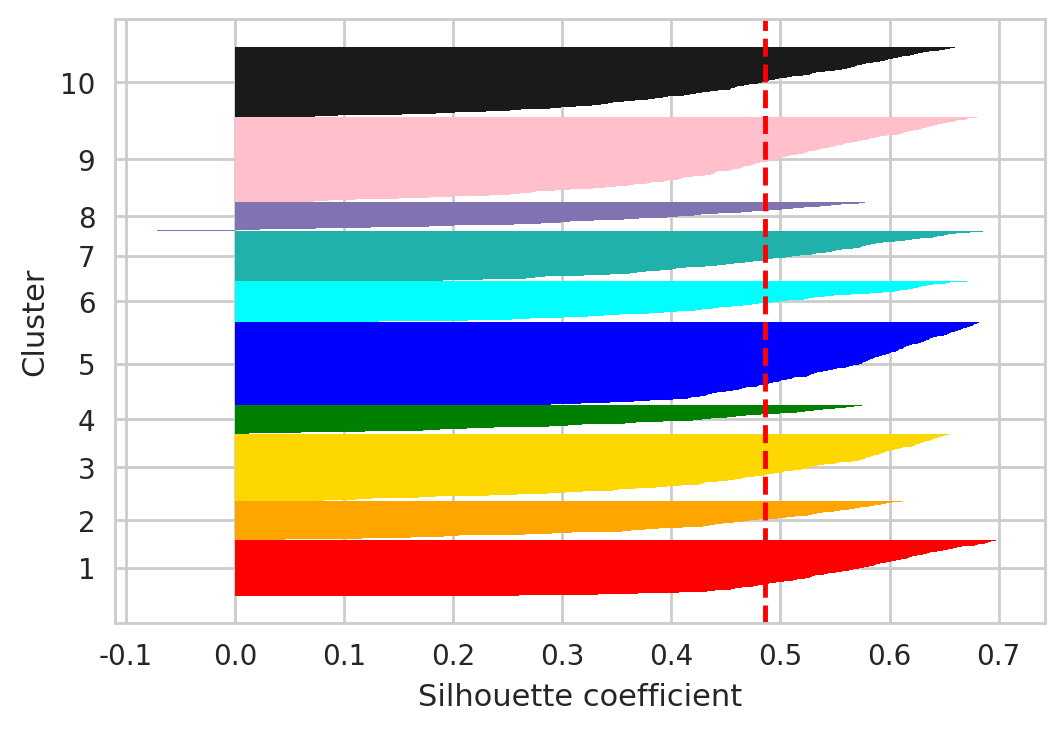

In [281]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

color = ["red", "orange", "gold", "green", "blue", "cyan", "lightseagreen", "m", "pink", "k"]

silhouette_vals = silhouette_samples(pcaX, model, metric="euclidean")
cluster_labels = np.unique(model)
n_clusters = cluster_labels.shape[0]

y_ax_lower, y_ax_upper = 0, 0

yticks = []


plt.figure(dpi=200)

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[model == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    #color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             edgecolor="none",
             color=color[i],
             height = 1.0
            )
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.show()
            

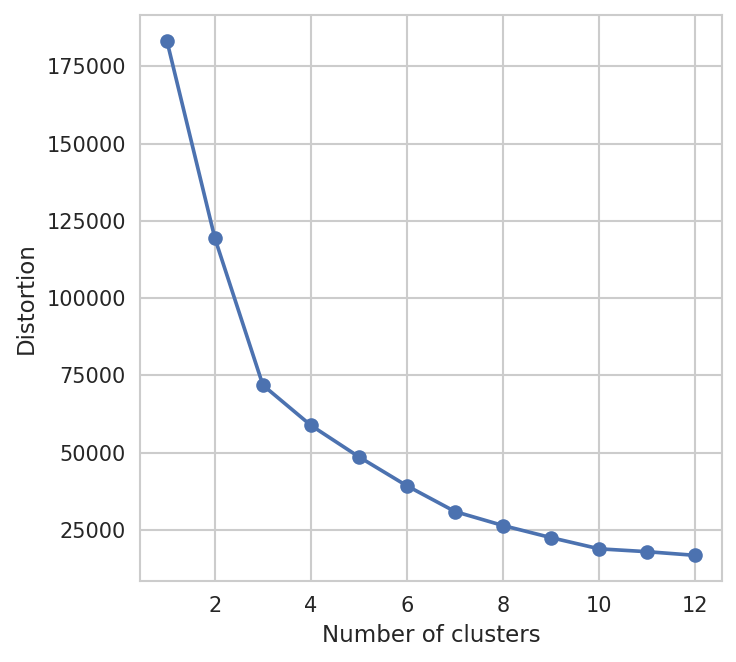

In [282]:
distortions = []
X = data.iloc[:,2:]
for i in range(1,13):
    model = KMeans(n_clusters=i, init="k-means++", random_state=0).fit(pcaX)
    distortions.append(model.inertia_)

plt.figure(figsize=(5,5),dpi=150)
plt.plot(range(1,13), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.show()

-----

# LDA

In [580]:
from sklearn.lda import LDA
lda = LDA(n_components=2)
ldaDf = lda.fit_transform(dfX, dfy)

In [581]:
lda.explained_variance_ratio_

array([ 0.82617866,  0.130584  ])

In [582]:
ldaDf = pd.DataFrame(ldaDf)

In [583]:
dfy = dfy.reset_index()
del dfy["index"]
ldaDf["pos"] = dfy

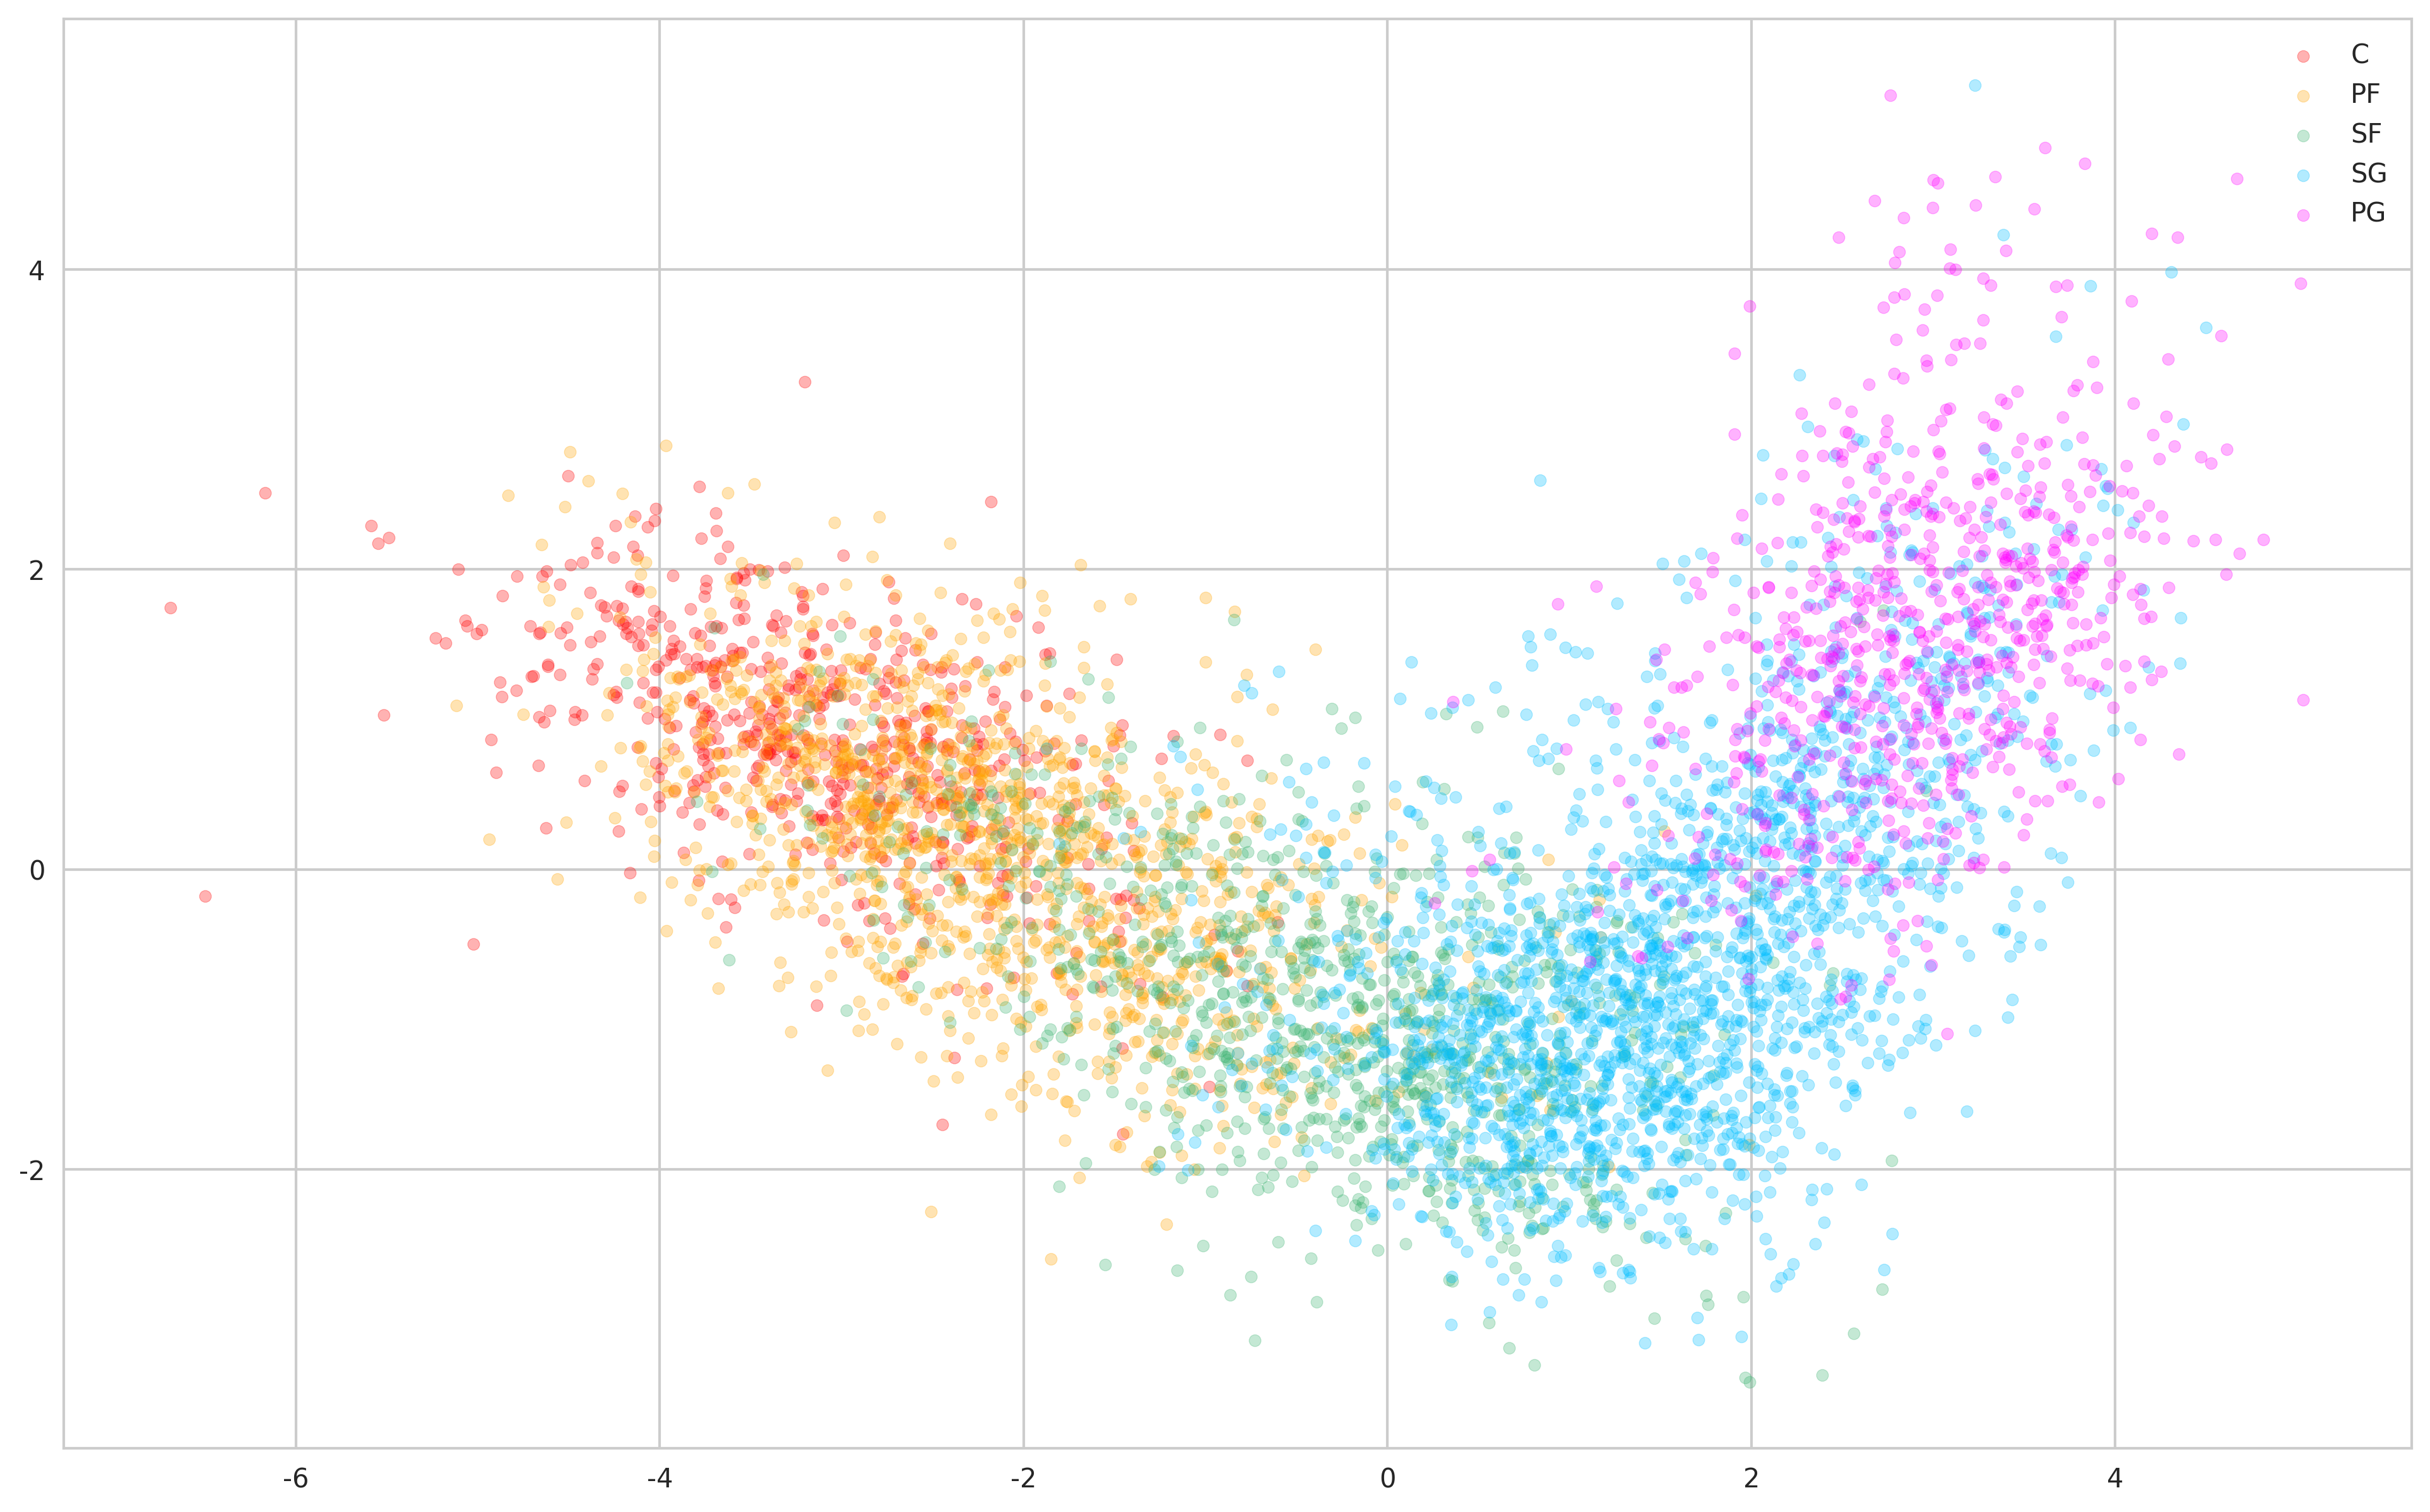

In [584]:
plt.figure(figsize=(16,10),dpi=300)
plt.scatter(ldaDf[ldaDf["pos"]=="C"].iloc[:,0], ldaDf[ldaDf["pos"]=="C"].iloc[:,1], color="red", marker="o", s=20, alpha=0.3, label="C")
plt.scatter(ldaDf[ldaDf["pos"]=="PF"].iloc[:,0], ldaDf[ldaDf["pos"]=="PF"].iloc[:,1], color="orange", marker="o", s=20, alpha=0.3, label="PF")
plt.scatter(ldaDf[ldaDf["pos"]=="SF"].iloc[:,0], ldaDf[ldaDf["pos"]=="SF"].iloc[:,1], color="mediumseagreen", marker="o", s=20, alpha=0.3, label="SF")
plt.scatter(ldaDf[ldaDf["pos"]=="SG"].iloc[:,0], ldaDf[ldaDf["pos"]=="SG"].iloc[:,1], color="deepskyblue", marker="o", s=20, alpha=0.3, label="SG")
plt.scatter(ldaDf[ldaDf["pos"]=="PG"].iloc[:,0], ldaDf[ldaDf["pos"]=="PG"].iloc[:,1], color="magenta", marker="o", s=20, alpha=0.3, label="PG")
plt.legend()
plt.show()

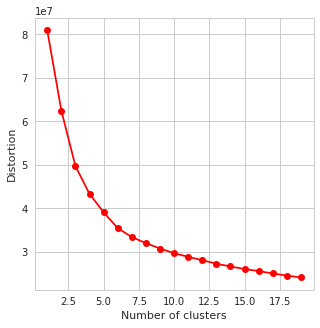

In [542]:
distortions = []
for i in range(1,20):
    model = KMeans(n_clusters=i, init="k-means++", random_state=0).fit(dfX)
    distortions.append(model.inertia_)

plt.figure(figsize=(5,5))
plt.plot(range(1,20), distortions, marker="o", color="red")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.show()

In [585]:
del ldaDf["pos"]

In [597]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init="k-means++").fit(ldaDf)

In [598]:
model.cluster_centers_

array([[  1.19391261e+00,  -2.21173006e-01,   6.00000000e+00],
       [ -2.65427450e+00,  -7.89870724e-02,   2.35367281e-14],
       [  2.61928874e+00,   6.64391370e-01,   1.00000000e+00],
       [ -1.30244060e+00,  -1.01897280e+00,   2.00000000e+00],
       [ -3.63433470e+00,   1.17245207e+00,   4.00000000e+00],
       [  3.21141796e+00,   2.30512344e+00,   5.00000000e+00],
       [  3.44725917e-01,  -1.53739230e+00,   3.00000000e+00],
       [ -7.47124556e-01,  -1.42211333e-01,   8.00000000e+00],
       [ -2.15970060e+00,   7.01106523e-01,   2.44249065e-14],
       [  1.76594430e+00,  -1.47163664e+00,   7.00000000e+00]])

In [599]:
model = model.predict(ldaDf)

In [600]:
ldaDf["cluster"] = model

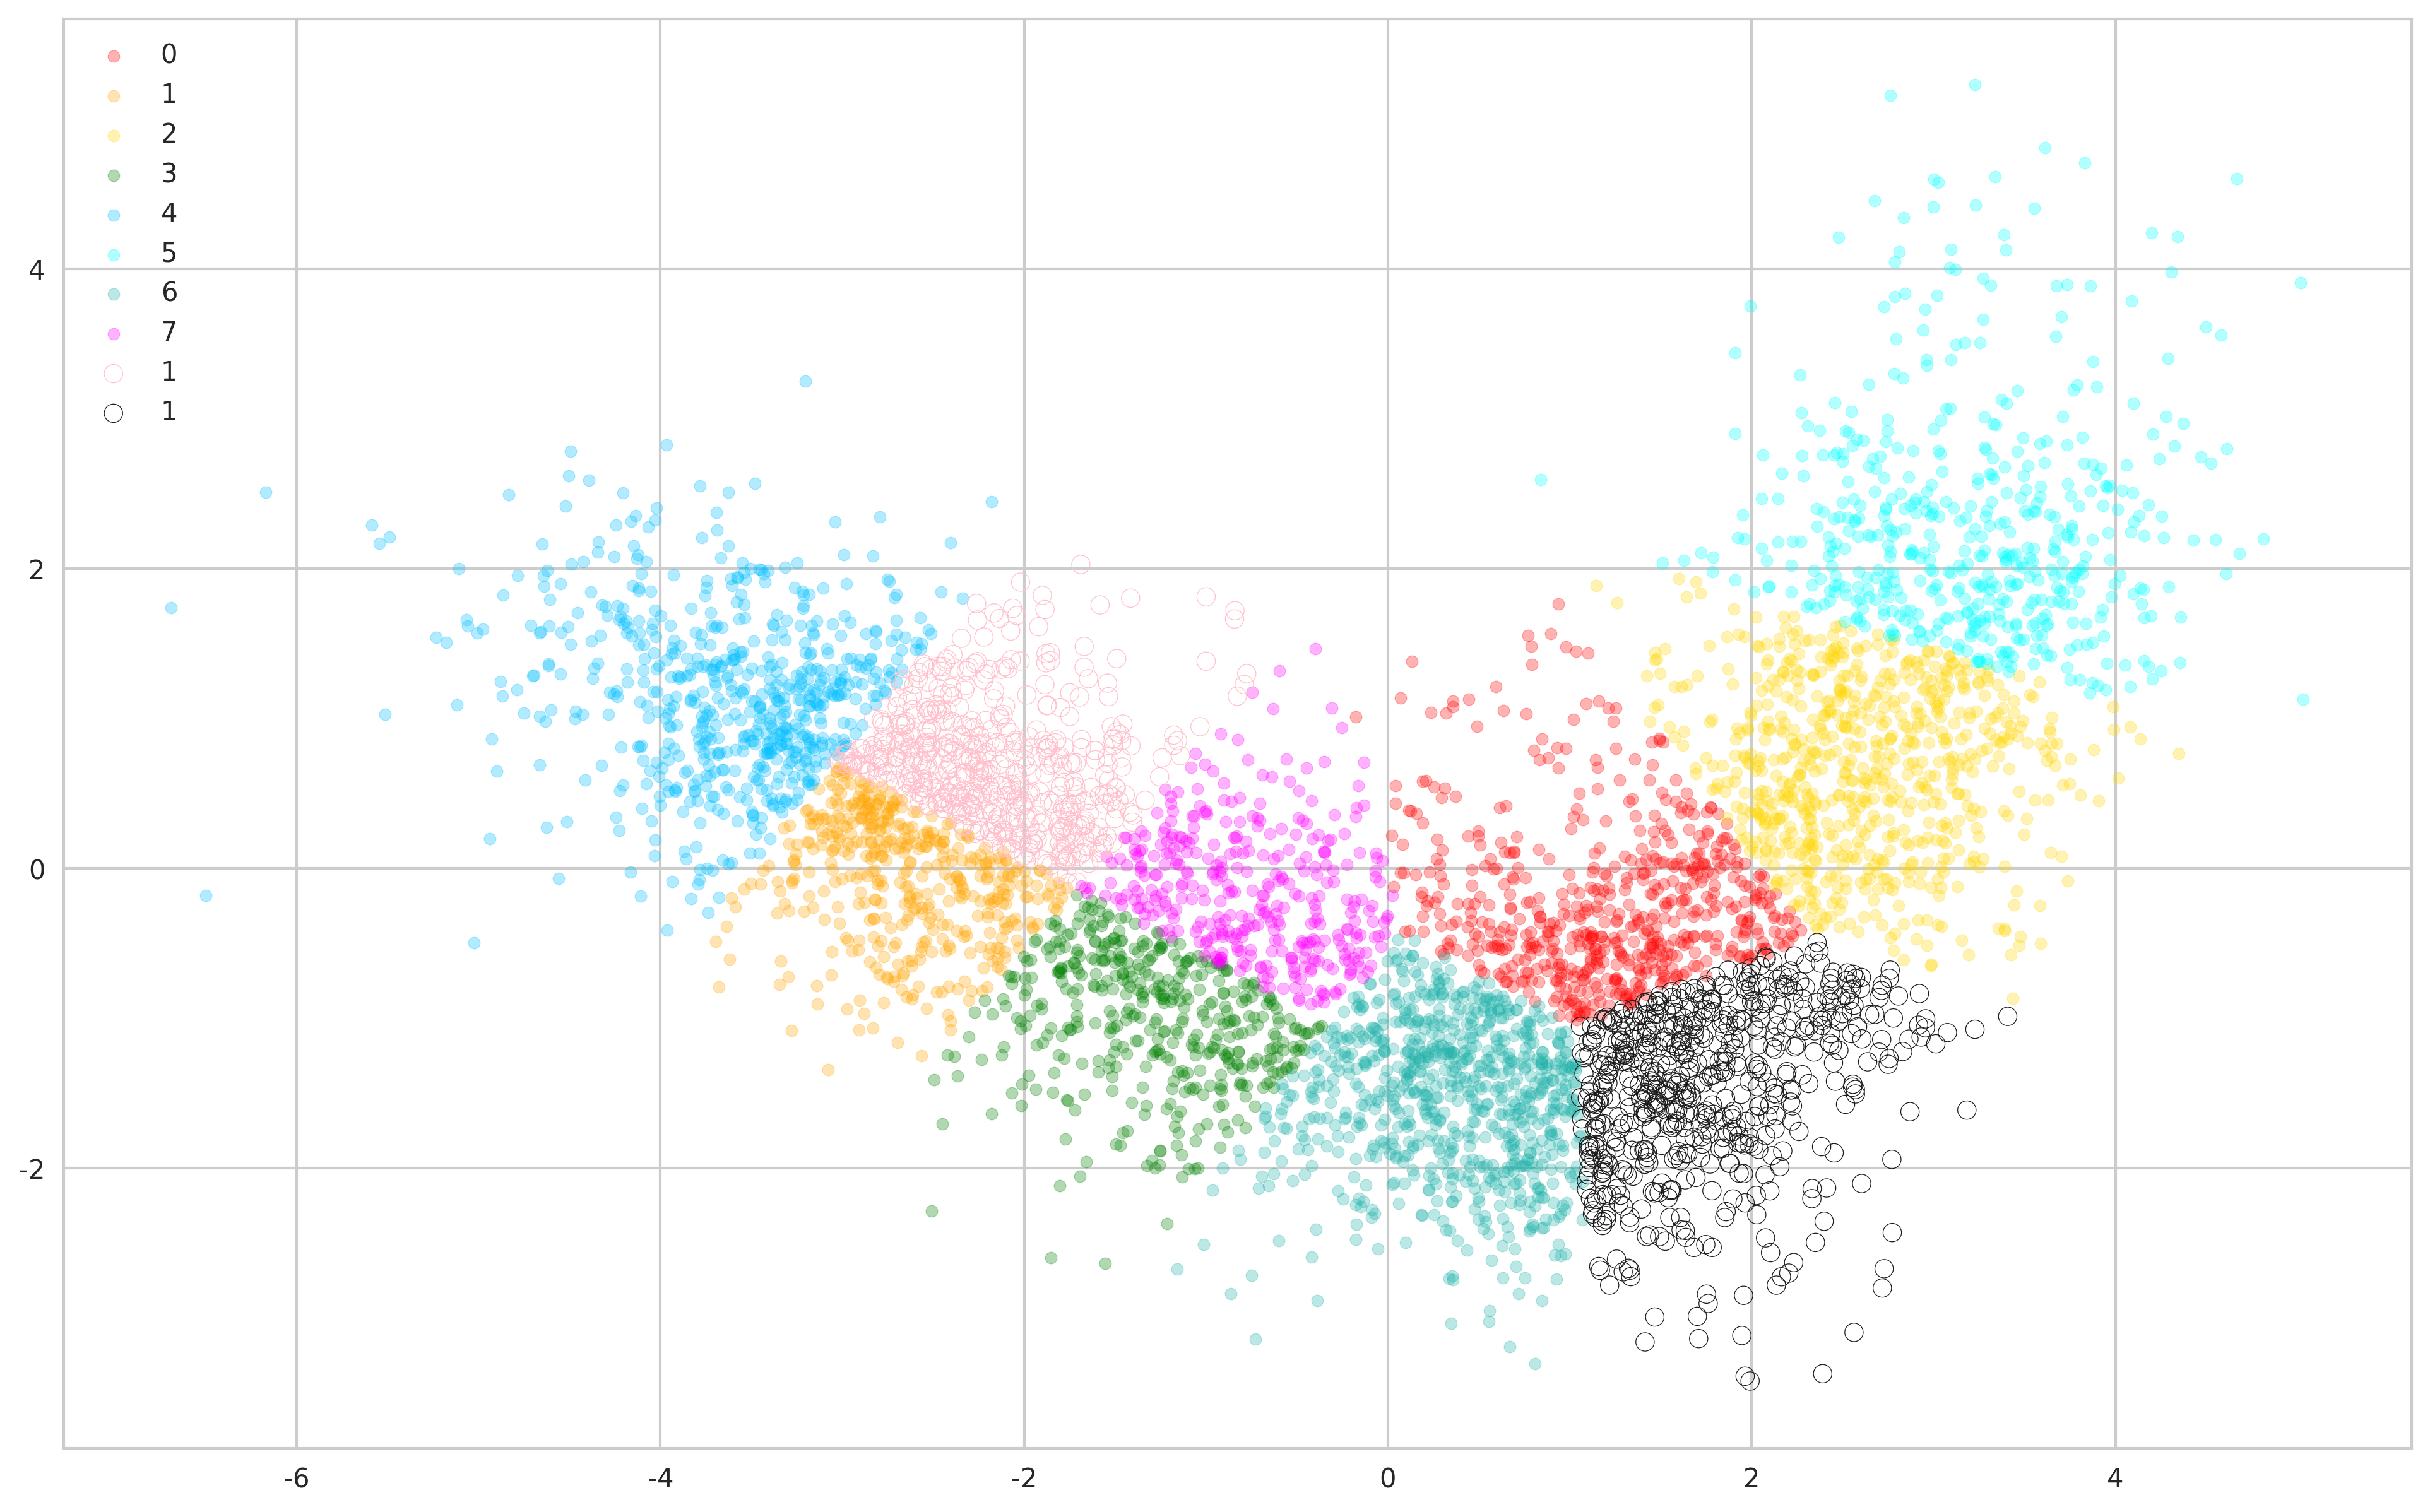

In [601]:
plt.figure(figsize=(16,10),dpi=300)
plt.scatter(ldaDf[ldaDf["cluster"]==0].iloc[:,0], ldaDf[ldaDf["cluster"]==0].iloc[:,1], color="red", marker="o", s=20, alpha=0.3, label="0")
plt.scatter(ldaDf[ldaDf["cluster"]==1].iloc[:,0], ldaDf[ldaDf["cluster"]==1].iloc[:,1], color="orange", marker="o", s=20, alpha=0.3, label="1")
plt.scatter(ldaDf[ldaDf["cluster"]==2].iloc[:,0], ldaDf[ldaDf["cluster"]==2].iloc[:,1], color="gold", marker="o", s=20, alpha=0.3, label="2")
plt.scatter(ldaDf[ldaDf["cluster"]==3].iloc[:,0], ldaDf[ldaDf["cluster"]==3].iloc[:,1], color="green", marker="o",s=20, alpha=0.3, label="3")
plt.scatter(ldaDf[ldaDf["cluster"]==4].iloc[:,0], ldaDf[ldaDf["cluster"]==4].iloc[:,1], color="deepskyblue", marker="o", s=20, alpha=0.3, label="4")
plt.scatter(ldaDf[ldaDf["cluster"]==5].iloc[:,0], ldaDf[ldaDf["cluster"]==5].iloc[:,1], color="cyan", marker="o",s=20, alpha=0.3, label="5")
plt.scatter(ldaDf[ldaDf["cluster"]==6].iloc[:,0], ldaDf[ldaDf["cluster"]==6].iloc[:,1], color="lightseagreen", marker="o",s=20, alpha=0.3, label="6")
plt.scatter(ldaDf[ldaDf["cluster"]==7].iloc[:,0], ldaDf[ldaDf["cluster"]==7].iloc[:,1], color="magenta", marker="o",s=20, alpha=0.3, label="7")
plt.scatter(ldaDf[ldaDf["cluster"]==8].iloc[:,0], ldaDf[ldaDf["cluster"]==8].iloc[:,1], color="pink", marker="o", facecolors="none")
plt.scatter(ldaDf[ldaDf["cluster"]==9].iloc[:,0], ldaDf[ldaDf["cluster"]==9].iloc[:,1], color="k", marker="o", facecolors="none")
plt.legend()
plt.show()

In [608]:
train.groupby("cluster").mean()

Games  Above the Break 3-Usage  Mid-Range-Usage  \
cluster                                                        
0        64.425210                20.631176        32.877513   
1        67.096197                 2.359396        33.676689   
2        66.982955                22.006349        33.425881   
3        67.231293                11.403175        36.677029   
4        67.614173                 0.364803        21.054425   
5        68.423002                23.404581        33.222144   
6        67.457711                18.643408        32.477960   
7        65.024390                11.760867        32.294255   
8        64.822669                 1.573638        29.351718   
9        69.190556                22.737875        31.122901   

         In The Paint (Non-RA)-Usage  Restricted Area-Usage  \
cluster                                                       
0                          11.446252              27.067395   
1                          18.633579              44.662058   
2                          11.180767              26.386847   
3                          13.988345              33.558163   
4                          22.938646              55.473921   
5                          12.304795              26.119142   
6                           9.972289              27.713955   
7                          13.903279              38.433279   
8                          18.858921              49.797605   
9                           8.671922              23.705025   

         Right Corner 3-Usage  Left Corner 3-Usage  Above the Break 3 %  \
cluster                                                                   
0                    3.726756             4.005966             0.319252   
1                    0.300336             0.291432             0.138984   
2                    3.151435             3.499304             0.320854   
3                    2.167868             2.080839             0.273125   
4                    0.035701             0.053748             0.037208   
5                    2.080078             2.453158             0.329458   
6                    5.452438             5.569092             0.314386   
7                    1.623713             1.812493             0.224862   
8                    0.133254             0.158757             0.077563   
9                    6.678499             6.859680             0.335793   

         Mid-Range %  In The Paint (Non-RA) %  Restricted Area %  \
cluster                                                            
0           0.374911                 0.371054           0.566834   
1           0.370837                 0.391322           0.615814   
2           0.384395                 0.370432           0.543950   
3           0.380621                 0.374351           0.605442   
4           0.339482                 0.385291           0.610483   
5           0.397788                 0.382885           0.544819   
6           0.368368                 0.352892           0.598219   
7           0.362201                 0.356423           0.584393   
8           0.345516                 0.367207           0.597358   
9           0.385030                 0.348857           0.589671   

         Right Corner 3 %  Left Corner 3 %  Personal Fouls PG  Charges Drawn  \
cluster                                                                        
0                0.338193         0.331002           1.852101       0.890756   
1                0.083978         0.090367           2.585794       1.161074   
2                0.349109         0.367249           1.811278       1.090909   
3                0.304633         0.271812           2.330476       1.188209   
4                0.013261         0.012770           2.682929       1.746457   
5                0.317253         0.359405           2.058265       1.908382   
6                0.374689         0.356480           1.970796       0.741294   
7                0.197501         0.229772       

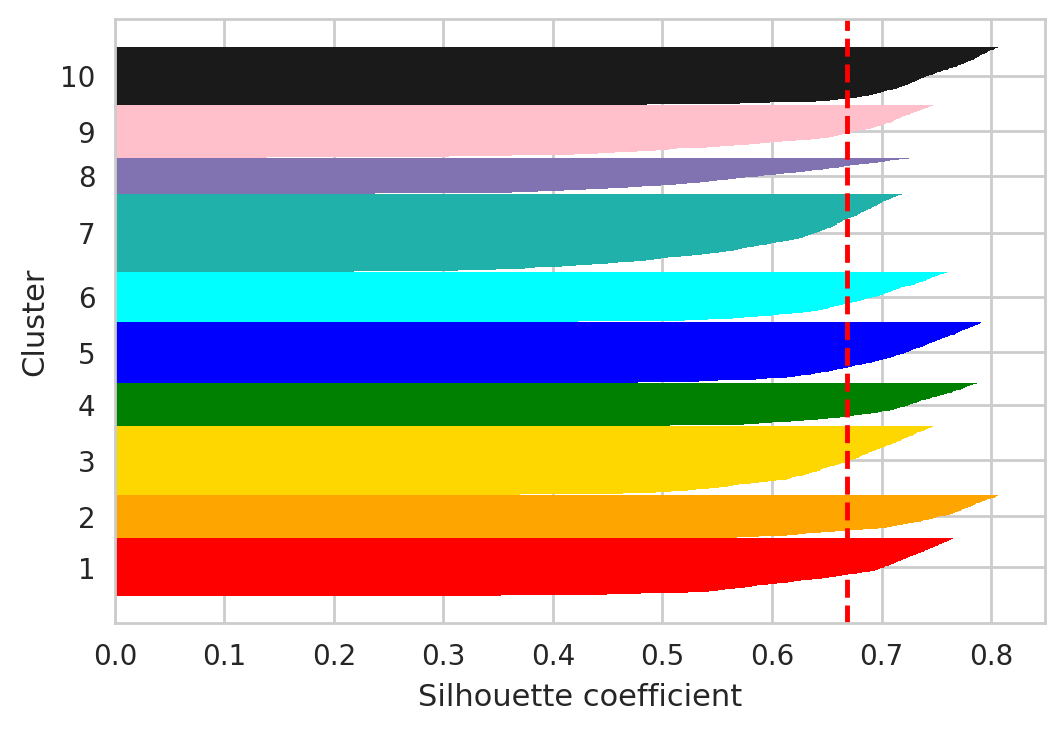

In [602]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

color = ["red", "orange", "gold", "green", "blue", "cyan", "lightseagreen", "m", "pink", "k"]

silhouette_vals = silhouette_samples(ldaDf, model, metric="euclidean")
cluster_labels = np.unique(model)
n_clusters = cluster_labels.shape[0]

y_ax_lower, y_ax_upper = 0, 0

yticks = []


plt.figure(dpi=200)

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[model == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    #color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             edgecolor="none",
             color=color[i],
             height = 1.0
            )
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.show()
            

In [604]:
ldaDf["cluster"].value_counts()

6    804
2    704
4    635
0    595
9    593
8    547
5    513
1    447
3    441
7    369
Name: cluster, dtype: int64

In [605]:
train = train.reset_index()
del train["index"]

In [606]:
train["cluster"] = ldaDf["cluster"]

In [607]:
train[train["Player"]=="Stephen Curry"]

Player      Team     Season Season Type  Games  \
6    Stephen Curry  Warriors  2015-2016         REG     79   
107  Stephen Curry  Warriors  2013-2014         REG     78   
112  Stephen Curry  Warriors  2014-2015         REG     80   
139  Stephen Curry  Warriors  2012-2013         REG     78   
496  Stephen Curry  Warriors  2010-2011         REG     74   
622  Stephen Curry  Warriors  2009-2010         REG     80   

     Above the Break 3-Usage  Mid-Range-Usage  In The Paint (Non-RA)-Usage  \
6                      47.46            12.35                         7.40   
107                    38.47            29.57                         9.69   
112                    41.54            21.37                         9.37   
139                    36.38            33.65                        11.46   
496                    24.03            35.99                        12.82   
622                    26.42            38.23                         8.49   

     Restricted Area-Usage  Right Corner 3-Usage  Left Corner 3-Usage  \
6                    24.76                  3.32                 4.01   
107                  16.27                  1.74                 3.90   
112                  21.15                  3.17                 2.87   
139                  11.67                  2.52                 3.89   
496                  18.71                  3.23                 4.84   
622                  20.03                  2.45                 3.85   

     Above the Break 3 %  Mid-Range %  In The Paint (Non-RA) %  \
6                  0.452        0.431                    0.500   
107                0.425        0.487                    0.425   
112                0.429        0.410                    0.484   
139                0.446        0.435                    0.396   
496                0.419        0.488                    0.363   
622                0.417        0.435                    0.392   

     Restricted Area %  Right Corner 3 %  Left Corner 3 %  Personal Fouls PG  \
6                0.656             0.491            0.484               2.04   
107              0.600             0.375            0.481               2.49   
112              0.664             0.548            0.632               1.98   
139              0.543             0.600            0.481               2.54   
496              0.609             0.500            0.549               3.15   
622              0.585             0.643            0.500               3.15   

     Charges Drawn  Off. Fouls Drawn  Off. Fouls  Defensive 3 Seconds  \
6                7                26           6                    0   
107              7                36          15                    2   
112             12                29           9                    0   
139              7                28           6                    2   
496              9                26          14                    4   
622              0                33          10                    3   

     Shooting Fouls Committed  Lost Ball Fouls  Defensive Goaltendings  \
6                          92                3                       0   
107                       124                6                       0   
112                        94                1                       0   
139                       115                2                       0   
496                       148                5                       0   
622                       173                9                       0   

     Blocks Against  Total Points  FGM_x  FGA_x  FG%_x  3FGM  3FGA   3FG%  \
6                51           137     38     86  0.442    16    42  0.381   
107              34           137     46    112  0.411    14    50  0.280   
112              36            85     25     55  0.455     4    18  0.222   
139              45           104     25     67  0.373     9    32  0.281   
496              40            85     27     54  0.500    10    26  0.385   
6

In [545]:
clus = []
for i in range(8):
    c = train[train["cluster"]==i] 
    del c["Pos"]
    clus.append(c)

In [546]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

# 데이터를 넣고 n에는 몇 개의 주성분으로 만들 것인지에 대한 정수
# 표준화 + PCA 다 해주는 함수 
def pca(data, n):
    data = StandardScaler().fit_transform(data)
    data = pd.DataFrame(data)
    col = [ "PC" + str(x+1) for x in range(n)]
    tempPCA = sklearnPCA(n_components=n)
    newIndex = tempPCA.fit_transform(data)
    newData = pd.DataFrame(newIndex)
    newData.columns = col
    return newData, tempPCA

In [547]:
pca_cluster = []
PCA_cluster = []
for i in clus:
    a, b = pca(i.iloc[:,4:], 2)
    pca_cluster.append(a)
    PCA_cluster.append(b)

In [553]:
def pcacomp(i, b):
    print("")
    print("1. expalined_variance_ratio")
    print("    - PC1 :", PCA_cluster[i].explained_variance_ratio_[0])
    print("    - PC2 :", PCA_cluster[i].explained_variance_ratio_[1])
    print("")
    print("-----------------------------------------------------")
    print("")
    print("2. components matrix")
    comp = pd.DataFrame(PCA_cluster[i].components_.T, index = train.iloc[:,4:92].columns)
    print(comp.sort_values(by=b, ascending=False))

In [556]:
pcacomp(2, 0)


1. expalined_variance_ratio
    - PC1 : 0.28235239724
    - PC2 : 0.100537528364

-----------------------------------------------------

2. components matrix
                                         0         1
Pts                               0.186764  0.029072
FGM_y                             0.182291  0.012184
FGA_y                             0.181673  0.027435
FGA_x                             0.180157  0.044247
Total Points                      0.179456  0.050542
FGM_x                             0.175289  0.038358
FTA_y                             0.175016 -0.072847
FTM_y                             0.174416 -0.050108
Min                               0.172733  0.036864
Last Min. FGA                     0.169523  0.051189
FTA_x                             0.168542  0.009778
FTM_x                             0.165509  0.021281
Completed Three Point Plays       0.165451 -0.072735
Ast                               0.164044 -0.013694
And One                           0.162770 -0.

In [561]:
train.head()

Player       Team     Season Season Type  Games  \
0   Kobe Bryant     Lakers  2005-2006         REG     80   
1  Kevin Durant    Thunder  2013-2014         REG     81   
2   Kobe Bryant     Lakers  2006-2007         REG     77   
3  LeBron James  Cavaliers  2005-2006         REG     79   
4  LeBron James       Heat  2011-2012        POFF     23   

   Above the Break 3-Usage  Mid-Range-Usage  In The Paint (Non-RA)-Usage  \
0                    21.72            44.91                        10.45   
1                    27.43            30.15                        16.29   
2                    20.66            42.74                        11.50   
3                    16.46            34.56                         8.01   
4                    14.14            28.88                        18.13   

   Restricted Area-Usage  Right Corner 3-Usage  Left Corner 3-Usage  \
0                  20.75                  1.15                 0.87   
1                  24.47                  1.13                 0.47   
2                  23.11                  1.08                 0.80   
3                  36.64                  2.47                 1.59   
4                  36.06                  1.39                 1.39   

   Above the Break 3 %  Mid-Range %  In The Paint (Non-RA) %  \
0                0.350        0.424                    0.493   
1                0.391        0.444                    0.404   
2                0.344        0.439                    0.480   
3                0.340        0.384                    0.370   
4                0.239        0.359                    0.451   

   Restricted Area %  Right Corner 3 %  Left Corner 3 %  Personal Fouls PG  \
0              0.601             0.280            0.474               2.91   
1              0.775             0.368            0.500               2.15   
2              0.613             0.421            0.286               2.66   
3              0.677             0.267            0.448               2.29   
4              0.751             0.429            0.286               2.04   

   Charges Drawn  Off. Fouls Drawn  Off. Fouls  Defensive 3 Seconds  \
0              0                12          48                    0   
1              0                 8          22                    1   
2              0                19          26                    5   
3              0                16          34                    3   
4              1                 7          10                    0   

   Shooting Fouls Committed  Lost Ball Fouls  Defensive Goaltendings  \
0                       112               12                       1   
1                       118                4                       2   
2                       103               13                       2   
3                        93                4                       1   
4                        23                2                       2   

   Blocks Against  Total Points  FGM_x  FGA_x  FG%_x  3FGM  3FGA   3FG%  \
0              82           167     48    132  0.364     7    32  0.219   
1              42           167     50    132  0.379    20    52  0.385   
2              76           220     62    156  0.397    12    42  0.286   
3              65           178     52     97  0.536     7    20  0.350   
4              20            46     10     27  0.370     3     8  0.375   

   FTM_x  FTA_x  FT%_x  Assisted FG Pct.  Blocked FG Pct.  Last Min. FGM  \
0     64     76  0.842             0.229            0.038             12   
1     47     57  0.825             0.440            0.030             15   
2     84    103  0.816             0.323            0.058             15   
3     67     99  0.677             0.231            0.062             18   
4     23     31  0.742             0.400            0.111              3   

   Last Min. FGA  Last Min. FG%  Avg. Shot Dist.  Avg. Made Shot Dist.  \
0             42          0.286            16.49                 14.